In [1]:
!pip install pmdarima
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.8 MB/s eta 0:00:00


In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('dse_cp_BSRMST.csv',sep=',', index_col='DATE', parse_dates=['DATE'], date_parser=dateparse).fillna(0)
stock_data
stock_data = stock_data.dropna()
print('shape of data' , stock_data.shape)
stock_data = stock_data.sort_values(by='DATE')
stock_data.head()

shape of data (245, 4)


<ipython-input-3-53f434a397b8>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


,#,TRADING CODE,CLOSEP*,YCP
DATE,,,,
2022-10-16,245,BSRMSTEEL,65.1,65.3
2022-10-17,244,BSRMSTEEL,63.9,65.1
2022-10-18,243,BSRMSTEEL,64.0,63.9
2022-10-19,242,BSRMSTEEL,64.1,64.0
2022-10-20,241,BSRMSTEEL,64.2,64.1


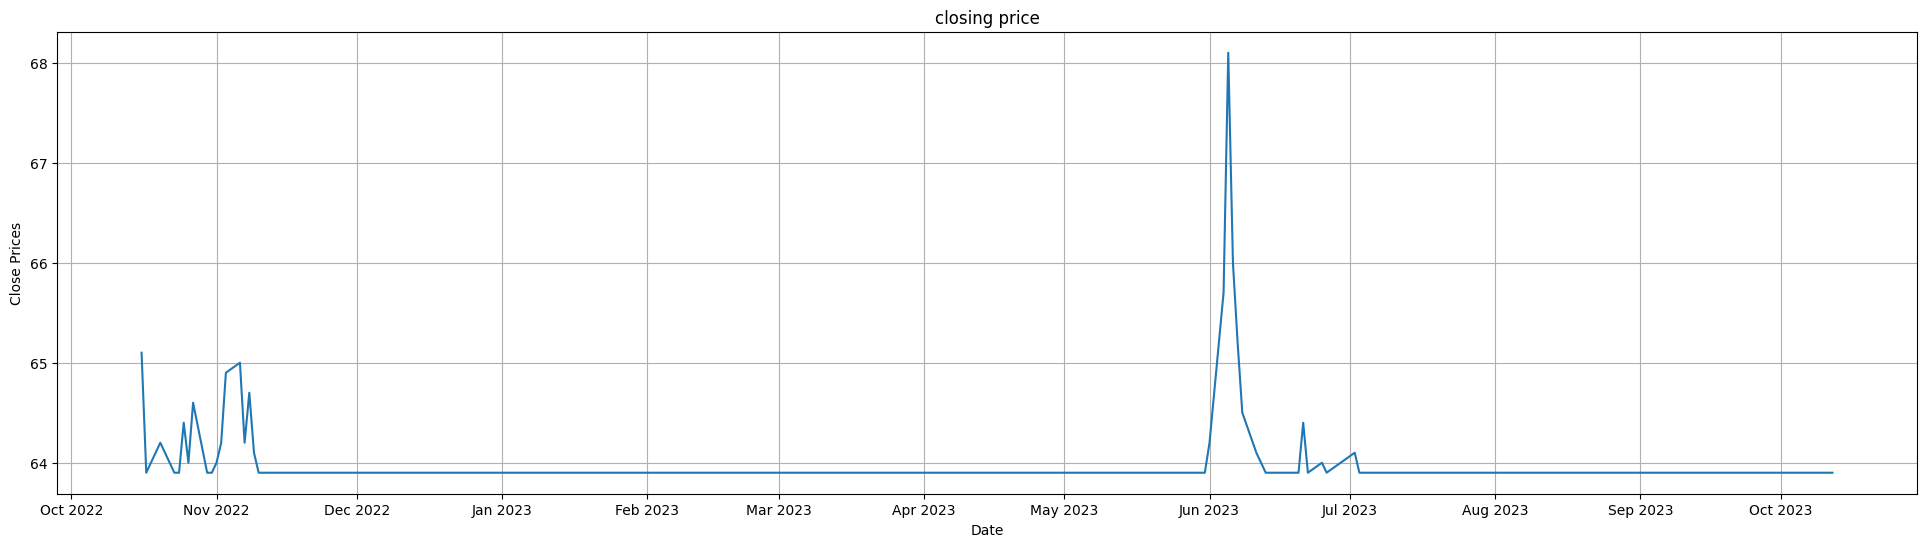

In [4]:
import matplotlib.dates as mdates
plt.figure(figsize=(24,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['CLOSEP*'])
plt.title('closing price')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.show()

In [5]:
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("2. P-value : ",dftest[1])

In [ ]:
 adf_test(stock_data['CLOSEP*'])

2. P-value :  1.7277324042049792e-09


In [6]:
df_close = stock_data['CLOSEP*']

In [ ]:
stock_data['price First Difference'] = df_close - df_close.shift(1)

In [ ]:
df_close.shift(1)

DATE
2021-10-12     NaN
2021-10-13    20.0
2021-10-14    19.1
2021-10-17    19.0
2021-10-18    18.3
              ... 
2023-10-05    30.6
2023-10-08    30.0
2023-10-09    28.7
2023-10-10    29.2
2023-10-11    30.2
Name: CLOSEP*, Length: 490, dtype: float64

In [ ]:
 adf_test(stock_data['price First Difference'].dropna())

2. P-value :  2.291161942443534e-11


<Axes: xlabel='DATE'>

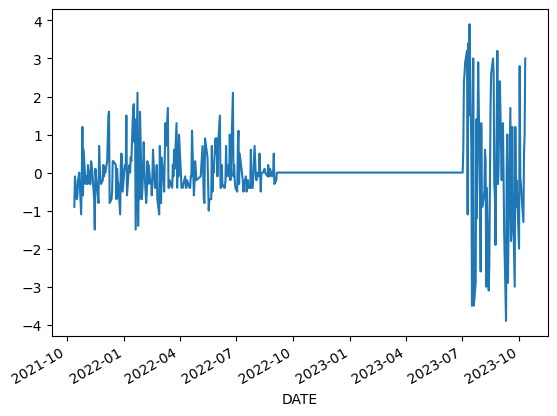

In [ ]:
stock_data['price First Difference'].plot()

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

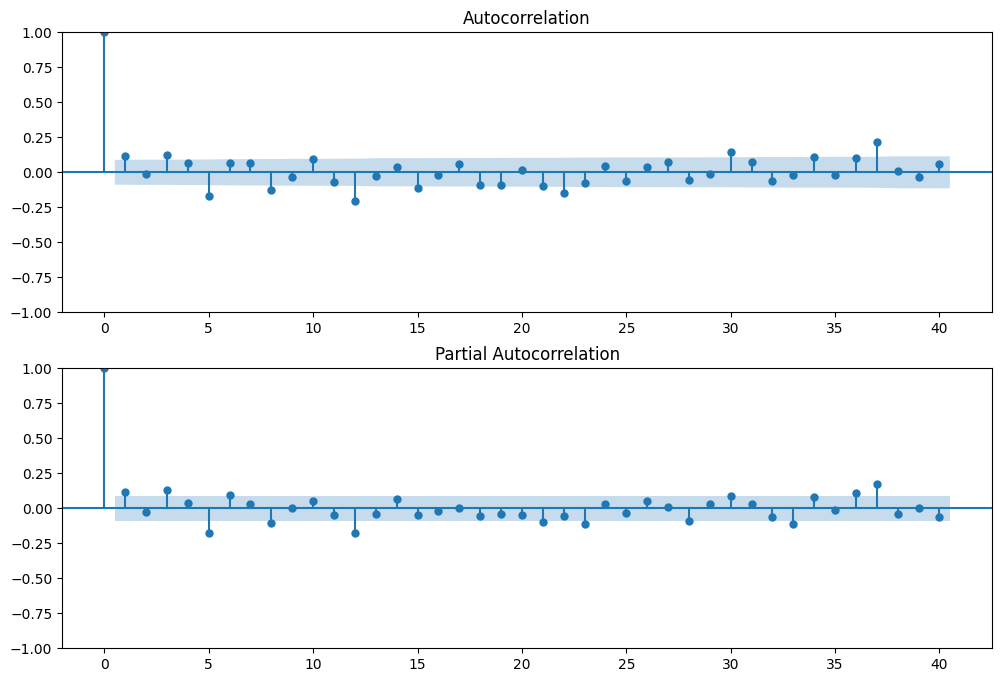

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock_data['price First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock_data['price First Difference'].dropna(),lags=40,ax=ax2)

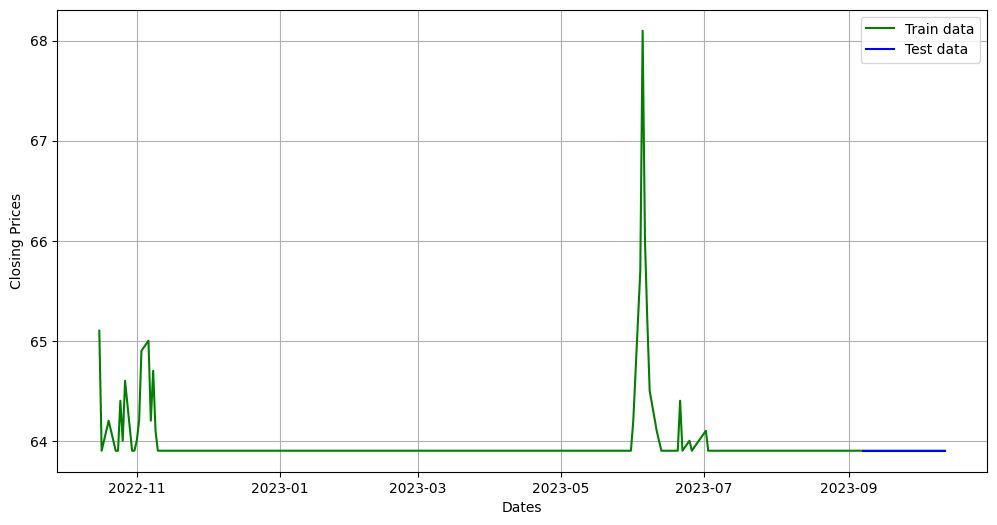

In [8]:
train_data, test_data = df_close[3:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,1,1))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: xlabel='DATE'>

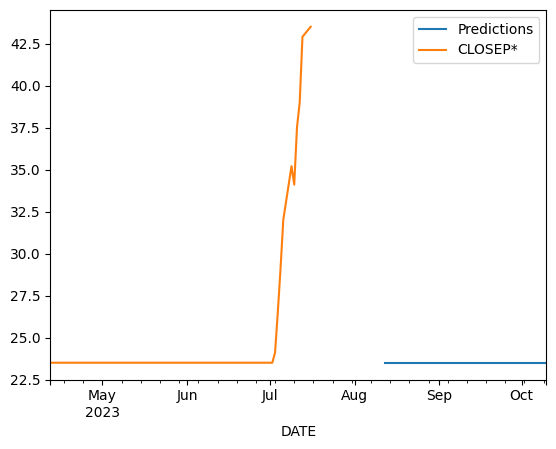

In [ ]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
index_future_dates=pd.date_range(start='2023-08-12',end='2023-10-10')
pred=fitted.predict(start=start,end=end,typ='levels').rename('Predictions')
pred.index=index_future_dates
pred.plot(legend=True)
test_data.plot(legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
test_data.mean()
rmse=sqrt(mean_squared_error(pred,test_data))
print("RMSE:",rmse)

mae = mean_absolute_error(test_data, pred)
print("MAE:", mae)

RMSE: 4.659917806549575
MAE: 4.117773180494399


In [9]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_close, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
auto_arima.summary()

In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,0,4))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_i

DATE
2023-10-12      1
2023-10-11      2
2023-10-10      3
2023-10-09      4
2023-10-08      5
             ... 
2022-10-20    241
2022-10-19    242
2022-10-18    243
2022-10-17    244
2022-10-16    245
Name: #, Length: 245, dtype: int64


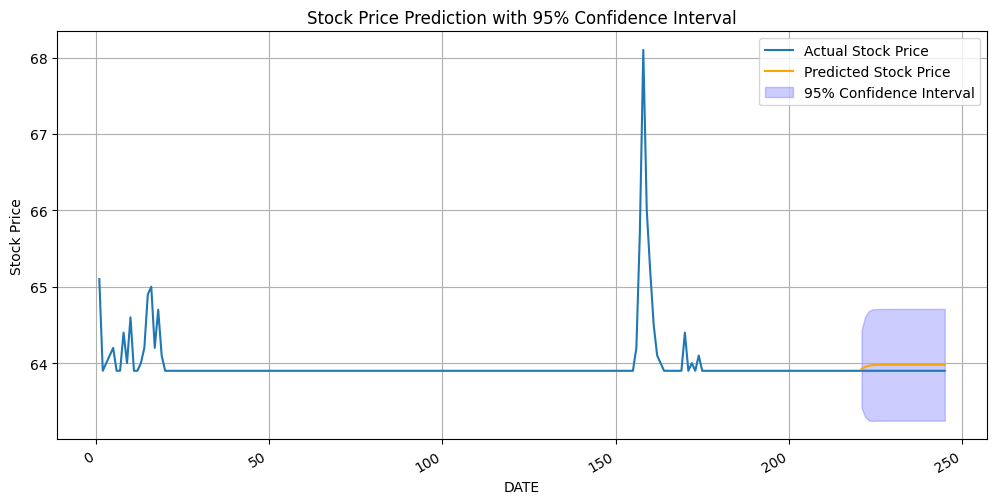

In [11]:
import matplotlib.pyplot as plt

# Sort the stock_data DataFrame by the 'DATE' (or '#') column in ascending order
stock_data.sort_values(by='#', inplace=True)

# Calculate indices
total = len(df_close)
test = len(test_data)
train = total - test

result = fitted.forecast(test, alpha=0.05)

# Confidence intervals
conf_ins = fitted.get_forecast(test).summary_frame()

# Create the plot with date labels on the x-axis and increased width
dates = stock_data['#']
print(dates)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the width (12) as needed
ax.plot(dates, df_close.values, label='Actual Stock Price')
ax.plot(dates[train:], result, label='Predicted Stock Price', color='orange')
ax.fill_between(dates[train:], conf_ins['mean_ci_lower'], conf_ins['mean_ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
ax.set_xlabel('DATE')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price Prediction with 95% Confidence Interval')
ax.legend()
fig.autofmt_xdate()
ax.grid(True)
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
test_data.mean()
rmse=sqrt(mean_squared_error(result,test_data))
print("RMSE:",rmse)

mae = mean_absolute_error(test_data, result)
print("MAE:", mae)

mape = mean_absolute_percentage_error(test_data, result)
print("MAPE:", mape)

RMSE: 0.07541293409436226
MAE: 0.07454997869204248
MAPE: 0.0011666663332088028


### 80

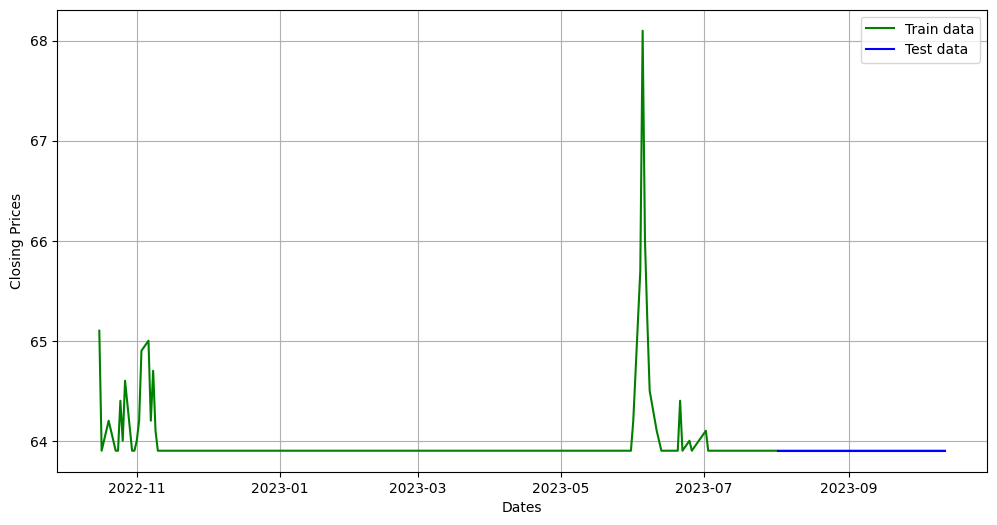

In [15]:
train_data, test_data = df_close[3:int(len(df_close)*0.8)], df_close[int(len(df_close)*0.8):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [16]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(0,1,5))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_i

DATE
2023-10-12      1
2023-10-11      2
2023-10-10      3
2023-10-09      4
2023-10-08      5
             ... 
2022-10-20    241
2022-10-19    242
2022-10-18    243
2022-10-17    244
2022-10-16    245
Name: #, Length: 245, dtype: int64


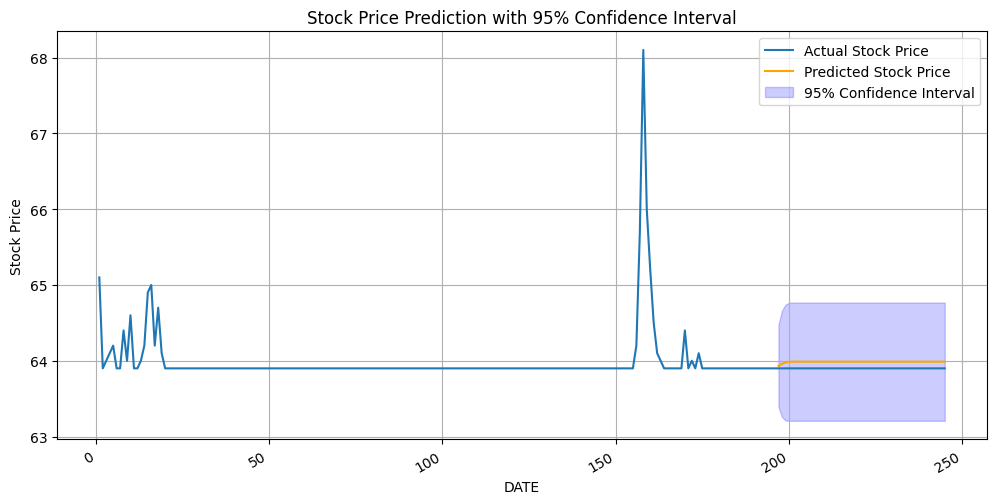

In [17]:
import matplotlib.pyplot as plt

# Sort the stock_data DataFrame by the 'DATE' (or '#') column in ascending order
stock_data.sort_values(by='#', inplace=True)

# Calculate indices
total = len(df_close)
test = len(test_data)
train = total - test

result = fitted.forecast(test, alpha=0.05)

# Confidence intervals
conf_ins = fitted.get_forecast(test).summary_frame()

# Create the plot with date labels on the x-axis and increased width
dates = stock_data['#']
print(dates)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the width (12) as needed
ax.plot(dates, df_close.values, label='Actual Stock Price')
ax.plot(dates[train:], result, label='Predicted Stock Price', color='orange')
ax.fill_between(dates[train:], conf_ins['mean_ci_lower'], conf_ins['mean_ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
ax.set_xlabel('DATE')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price Prediction with 95% Confidence Interval')
ax.legend()
fig.autofmt_xdate()
ax.grid(True)
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
test_data.mean()
rmse=sqrt(mean_squared_error(result,test_data))
print("RMSE:",rmse)

mae = mean_absolute_error(test_data, result)
print("MAE:", mae)

mape = mean_absolute_percentage_error(test_data, result)
print("MAPE:", mape)

RMSE: 0.08669697085935563
MAE: 0.0862364950263943
MAPE: 0.0013495539127761239


## 70%training

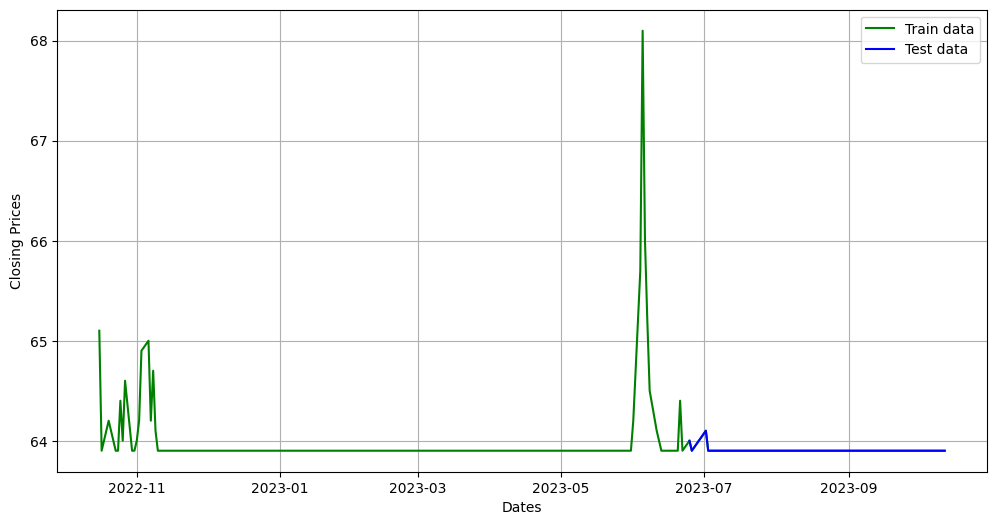

In [19]:
train_data, test_data = df_close[3:int(len(df_close)*0.7)], df_close[int(len(df_close)*0.7):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [20]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(0,1,5))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_i

DATE
2023-10-12      1
2023-10-11      2
2023-10-10      3
2023-10-09      4
2023-10-08      5
             ... 
2022-10-20    241
2022-10-19    242
2022-10-18    243
2022-10-17    244
2022-10-16    245
Name: #, Length: 245, dtype: int64


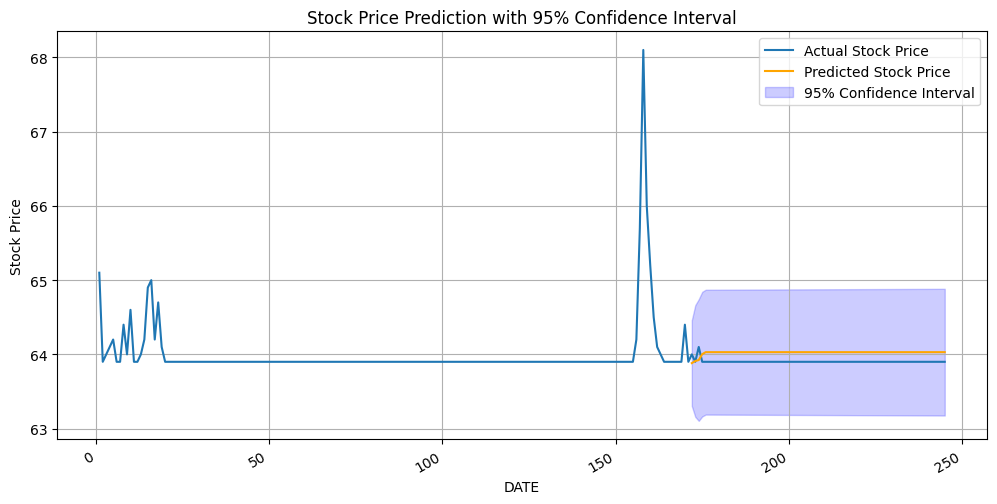

In [21]:
import matplotlib.pyplot as plt

# Sort the stock_data DataFrame by the 'DATE' (or '#') column in ascending order
stock_data.sort_values(by='#', inplace=True)

# Calculate indices
total = len(df_close)
test = len(test_data)
train = total - test

result = fitted.forecast(test, alpha=0.05)

# Confidence intervals
conf_ins = fitted.get_forecast(test).summary_frame()

# Create the plot with date labels on the x-axis and increased width
dates = stock_data['#']
print(dates)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the width (12) as needed
ax.plot(dates, df_close.values, label='Actual Stock Price')
ax.plot(dates[train:], result, label='Predicted Stock Price', color='orange')
ax.fill_between(dates[train:], conf_ins['mean_ci_lower'], conf_ins['mean_ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
ax.set_xlabel('DATE')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price Prediction with 95% Confidence Interval')
ax.legend()
fig.autofmt_xdate()
ax.grid(True)
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
test_data.mean()
rmse=sqrt(mean_squared_error(result,test_data))
print("RMSE:",rmse)

mae = mean_absolute_error(test_data, result)
print("MAE:", mae)

mape = mean_absolute_percentage_error(test_data, result)
print("MAPE:", mape)

RMSE: 0.12923654762901393
MAE: 0.12834003291109608
MAPE: 0.0020082960532537995
